# Final Model for VTA Ridership with Weather Data

## Import packages

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import (
    explained_variance_score,
    root_mean_squared_error,
    PredictionErrorDisplay,
    mean_absolute_error,
    r2_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
CLEAN_DATA_FOLDER = "clean_data"
MODELS_FOLDER = "models"

## Load the dataframe

In [3]:
df = pd.concat(
    [
        pd.read_csv(os.path.join(CLEAN_DATA_FOLDER, "train.csv")),
        pd.read_csv(os.path.join(CLEAN_DATA_FOLDER, "test.csv")),
    ],
    axis=0,
)

## Split into X and y

In [4]:
X = df[[x for x in df.columns if x not in ["On", "Off"]]]
y = df["On"]

## Train the Random Forest Regression Model using Tuned Parameters

{
    'min_samples_split': 14,
    'min_samples_leaf': 7,
    'criterion': 'poisson',
    'max_depth': 100,
    'max_features': 'sqrt',
    'n_estimators': 50
}

In [5]:
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=100,
    random_state=42,
    min_samples_split=14,
    min_samples_leaf=7,
    max_features="sqrt",
    criterion="poisson",
    n_jobs=-1,
    verbose=1,
)
rf = rf.fit(X=X, y=y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


In [6]:
y_pred = np.floor(rf.predict(X)).astype(int)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   18.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   29.5s finished


## Report Results

In [7]:
print("Root Mean Squared Error:", root_mean_squared_error(y, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y, y_pred))
print("Explained Variance Score:", explained_variance_score(y, y_pred))
print("R2 score:", r2_score(y, y_pred))

Root Mean Squared Error: 21.771256336270202
Mean Absolute Error: 5.7359326321284385
Explained Variance Score: 0.8051781363330925
R2 score: 0.8050824068967283


## Export Model

In [8]:
pickle.dump(rf, open(os.path.join(MODELS_FOLDER, "final_model.pkl"), "wb"))

## Visualize the Prediction errors

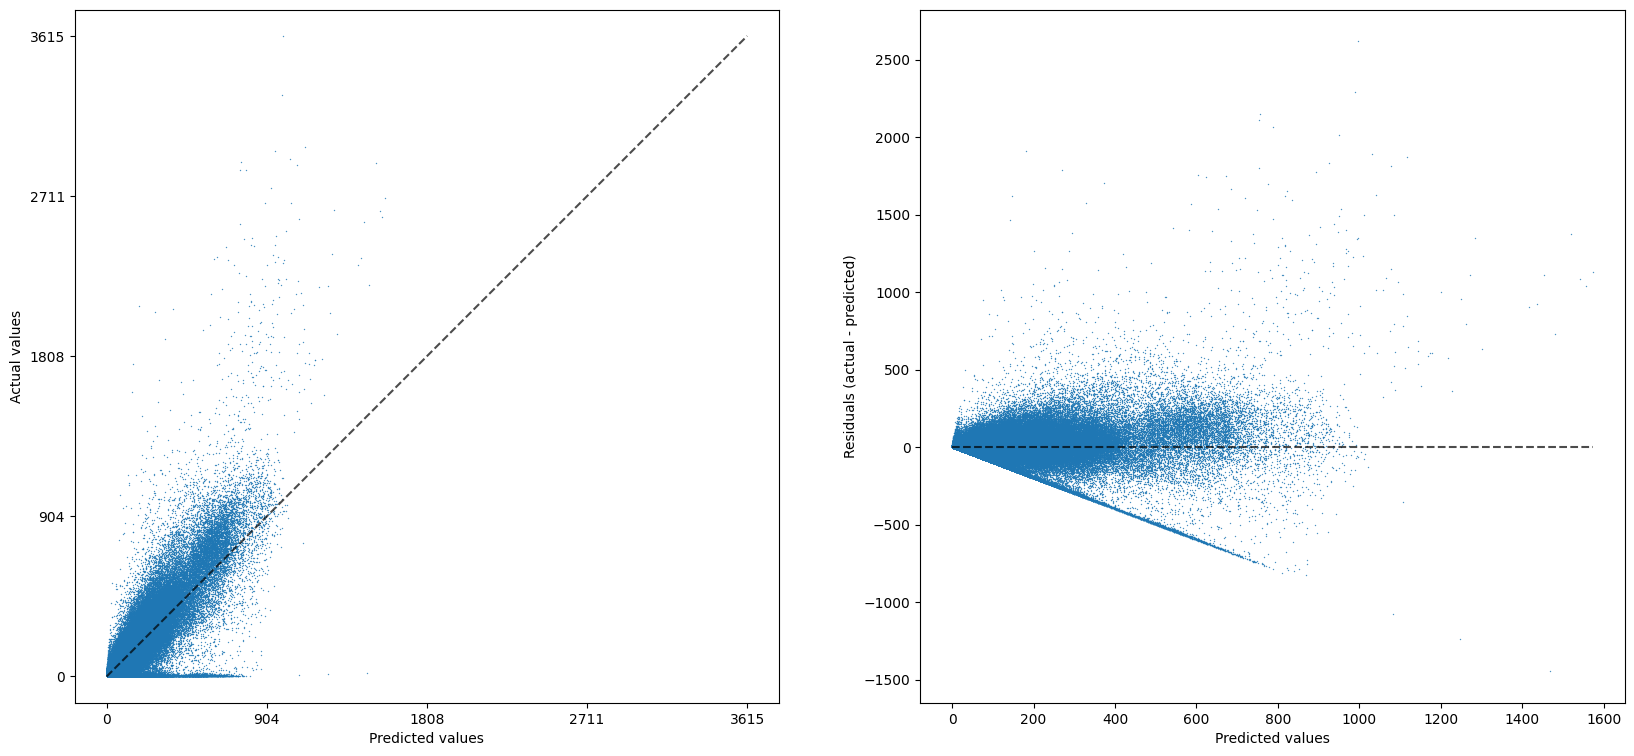

In [9]:
_, ax = plt.subplots(1, 2, figsize=(20, 9))
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
_ = display.plot(
    ax[0], kind="actual_vs_predicted", scatter_kwargs={"linewidth": 0, "s": 1}
)
_ = display.plot(
    ax[1], kind="residual_vs_predicted", scatter_kwargs={"linewidth": 0, "s": 1}
)

## Visualize the Internal Decision Trees

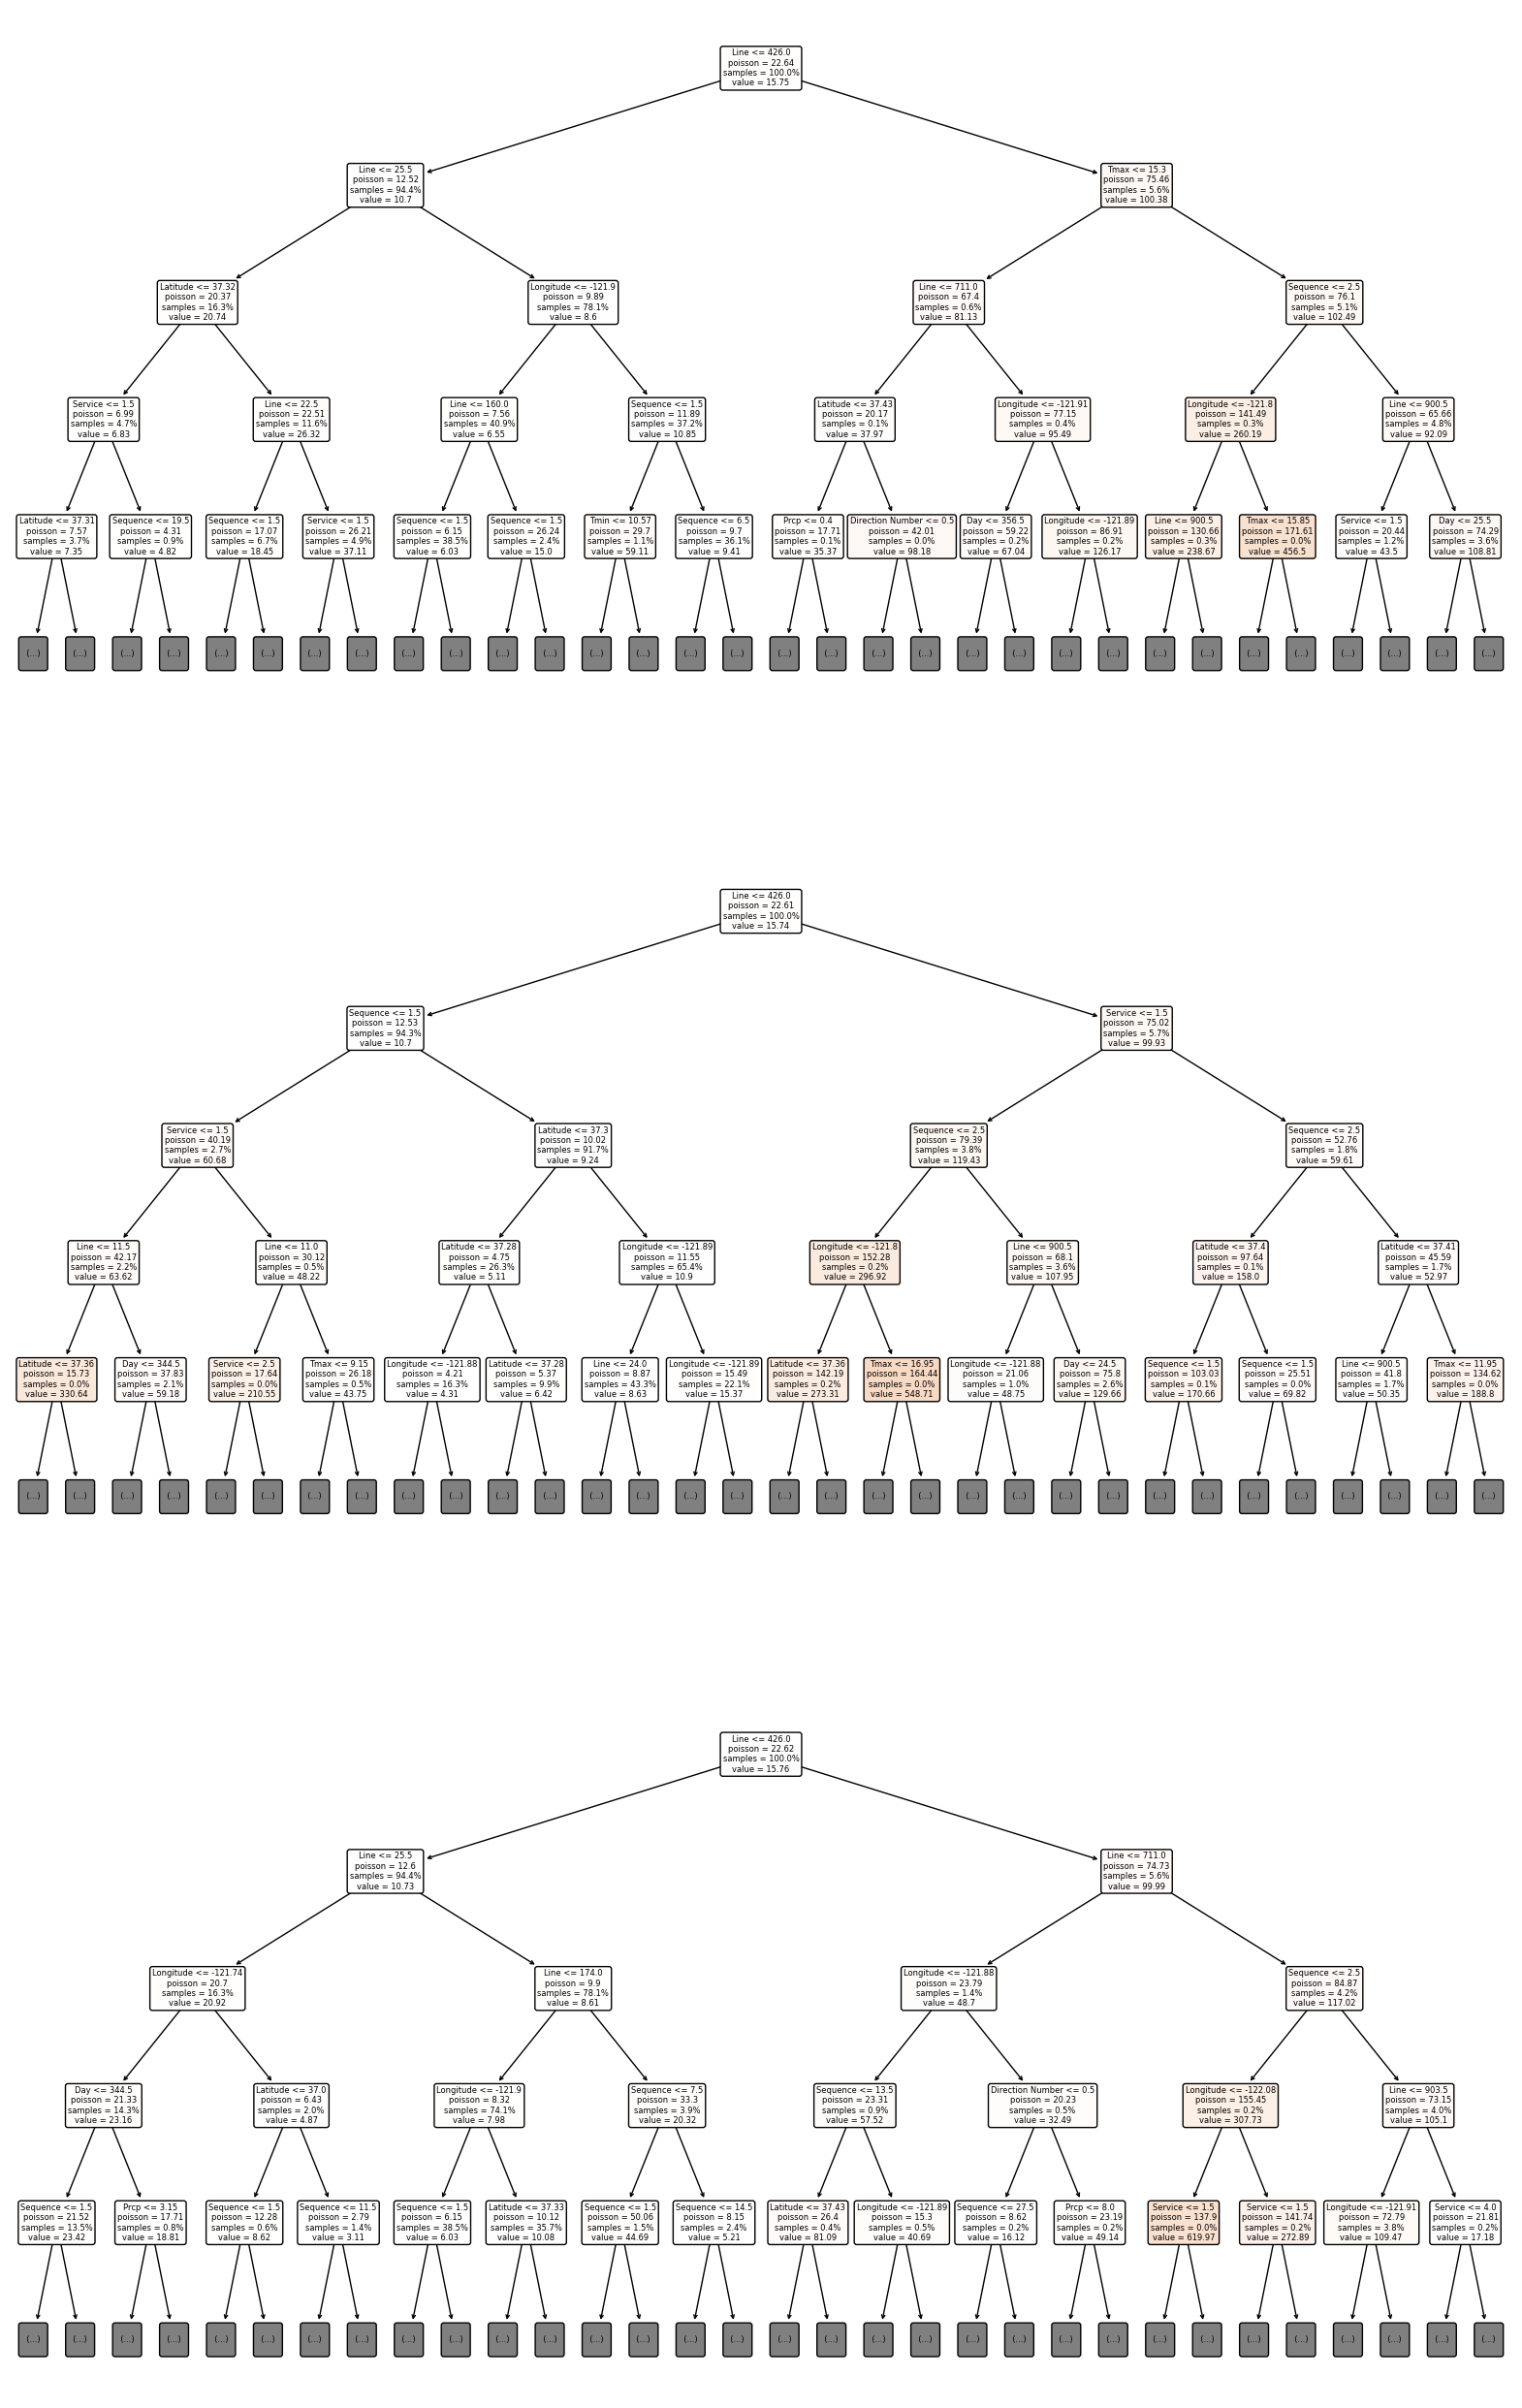

In [10]:
_, ax = plt.subplots(3, 1, figsize=(20, 32))
for i in range(3):
    _ = plot_tree(
        rf.estimators_[i * len(rf.estimators_) // 3],
        max_depth=4,
        feature_names=X.columns,
        filled=True,
        proportion=True,
        rounded=True,
        precision=2,
        fontsize=6,
        ax=ax[i],
    )

## Visualize the Feature Importance

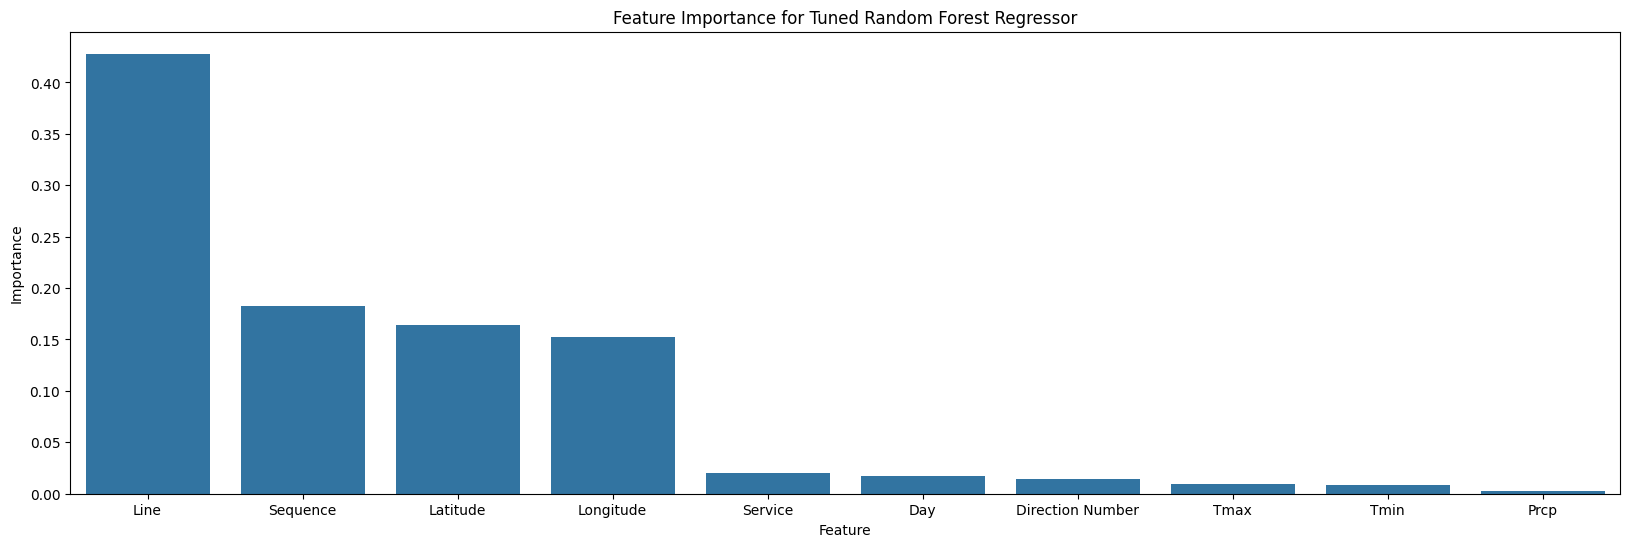

In [11]:
feat_imp = pd.DataFrame(
    {
        "Feature": [x for x in rf.feature_names_in_],
        "Importance": [x for x in rf.feature_importances_],
    }
)
feat_imp = feat_imp.sort_values("Importance", ascending=False)
_, ax = plt.subplots(1, 1, figsize=(20, 6))
_ = sns.barplot(feat_imp, x="Feature", y="Importance")
_ = plt.title("Feature Importance for Tuned Random Forest Regressor")